GAN: https://vbarra.github.io/DLbook/gan.html
VAE: https://vbarra.github.io/DLbook/vae.html

# 1. Setup and Data Handling

## 1.1. Environment Setup
Libraries: Install necessary libraries: tensorflow, keras, numpy, matplotlib, urllib (you can also add tqdm for progress bars). Consider using tensorflow-gpu if you have a compatible GPU.

Reproducibility: Set random seeds for TensorFlow and NumPy to ensure reproducibility.

Notebook Setup: Start your Jupyter Notebook and import all the necessary libraries in the first cell.

Constants: Define constants like IMAGE_SIZE, BATCH_SIZE, CLASSES, DATA_DIR, etc. at the beginning of your notebook.

Using Python 3.9.21

In [ ]:
!pip install tensorflow numpy matplotlib urllib3 jupyter tqdm

In [10]:
# General imports
import numpy as np
import os
import time
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from keras import layers

# For downloading Quick, Draw! data (if not already downloaded)
import urllib.request

# For progress bars (optional)
from tqdm import tqdm

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)
print(f"Keras version: {tf.keras.__version__}")

TensorFlow version: 2.18.0
NumPy version: 2.0.2
Keras version: 3.8.0


**Setting Random Seeds for Reproducibility**: 42 is a common choice (it's the "Answer to the Ultimate Question of Life, the Universe, and Everything" from The Hitchhiker's Guide to the Galaxy). The important thing is to use the same seed consistently to get the same results.

In [11]:
tf.random.set_seed(42) 
np.random.seed(42)   

In [12]:
# --- Constants ---
IMAGE_SIZE = 28       # Height and width of the images
CHANNELS = 1          # Number of channels in the images (grayscale)
BATCH_SIZE = 64       # Batch size for training
LATENT_DIM = 128      # Dimension of the VAE latent space
LATENT_DIM_GAN = 128  # Dimension of the GAN latent space (noise vector)
EPOCHS = 50           # Number of training epochs (you might need more)
CLASSES = ['cat', 'dog', 'bird', 'tree', 'house']  # Chosen classes
DATA_DIR = "quickdraw_data"  # Directory to store the data
MAX_ITEMS_PER_CLASS = 5000 # Limit the number of samples per class

## 1.2. Data Download and Preparation:

Class Selection: Choose your five classes: cat, dog, bird, tree, house.

Download: Use the provided download_quickdraw_data function (from the "Data Loading and Preparation" section) to download the .npy files for the chosen classes. This function efficiently checks if the files already exist locally.

Load Data: Use the load_quickdraw_data function to load the data into memory.

Important: Limit the number of samples per class using max_items_per_class (e.g., 5000 or 10000) to manage memory usage, especially if you're not using a GPU.

Reshape and Normalize: Reshape the data to (num_samples, 28, 28, 1) and normalize pixel values to the range [0, 1] (or [-1, 1] if you're using tanh in the GAN generator).

Split Data: Divide the data into training and testing sets (e.g., 80% train, 20% test).

One-Hot Encode Labels (Optional): If you plan to implement a Conditional GAN (cGAN) or explore class-conditional generation with the VAE, one-hot encode the labels using to_categorical.

In [13]:
# --- Data Download and Preparation ---
import os
import urllib.request
import numpy as np
from tqdm import tqdm  # Import tqdm

def download_quickdraw_data(classes, base_url="https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/"):
    """Downloads Quick, Draw! data if not already present."""
    for class_name in classes:
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(DATA_DIR, file_name)  # Use DATA_DIR constant
        if not os.path.exists(file_path):
            print(f"Downloading {file_name}...")
            with tqdm(unit="B", unit_scale=True, unit_divisor=1024, miniters=1) as t:
                urllib.request.urlretrieve(base_url + file_name, file_path, reporthook=lambda b, bsize, tsize: t.update(bsize))
        else:
            print(f"{file_name} already downloaded.")

def load_quickdraw_data(classes, max_items_per_class, data_dir=DATA_DIR):
    """Loads Quick, Draw! data into memory."""
    all_data = []
    all_labels = []
    for idx, class_name in enumerate(classes):
        file_name = f"{class_name.replace(' ', '_')}.npy"
        file_path = os.path.join(data_dir, file_name)
        try:
            data = np.load(file_path)
            if data.shape[0] > max_items_per_class:
                data = data[:max_items_per_class]
            all_data.append(data)
            all_labels.append(np.full((data.shape[0],), idx))
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")
            print("Please ensure the data has been downloaded correctly.")
            return None, None

    return np.concatenate(all_data), np.concatenate(all_labels)

# Download and load data
download_quickdraw_data(CLASSES)  # Use CLASSES constant
x_data, labels = load_quickdraw_data(CLASSES, MAX_ITEMS_PER_CLASS)  # Use CLASSES and MAX_ITEMS_PER_CLASS constants

# Skip if data loading failed
if x_data is None or labels is None:
    print("Data loading failed. Please check previous steps.")
else:
    # Reshape and normalize data
    x_data = x_data.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS).astype('float32') / 255.

    # Split into training and testing sets
    num_samples = len(x_data)
    train_size = int(0.8 * num_samples)
    x_train, x_test = x_data[:train_size], x_data[train_size:]
    y_train, y_test = labels[:train_size], labels[train_size:]

    # One-hot encode labels (optional, for conditional models or classification tasks)
    num_classes = len(CLASSES)
    y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes)

    # Print shapes
    print("x_train shape:", x_train.shape)
    print("y_train shape:", y_train.shape)
    print("x_test shape:", x_test.shape)
    print("y_test shape:", y_test.shape)

cat.npy already downloaded.
dog.npy already downloaded.
bird.npy already downloaded.
tree.npy already downloaded.
house.npy already downloaded.
x_train shape: (20000, 28, 28, 1)
y_train shape: (20000,)
x_test shape: (5000, 28, 28, 1)
y_test shape: (5000,)


# 2. Model Building

In [95]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Định nghĩa lớp Sampling
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
# Xây dựng encoder
def build_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    
    return keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

# Xây dựng decoder
def build_decoder(latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128, activation="relu")(latent_inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Reshape((7, 7, 128))(x)
    
    x = layers.Conv2DTranspose(128, 3, activation="relu", strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
    
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")

# Định nghĩa VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampling = Sampling()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def get_config(self):
        config = super().get_config()
        config.update({
            "encoder": self.encoder.get_config(),
            "decoder": self.decoder.get_config(),
        })
        return config

    @classmethod
    def from_config(cls, config):
        encoder = keras.Model.from_config(config.pop("encoder"))
        decoder = keras.Model.from_config(config.pop("decoder"))
        return cls(encoder=encoder, decoder=decoder, **config)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampling([z_mean, z_log_var])
            reconstruction = self.decoder(z)
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Khởi tạo model
latent_dim = 128
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
vae = VAE(encoder, decoder)

# Compile và train
vae.compile(optimizer=keras.optimizers.Adam())

### GAN model

In [34]:
# --- Improved GAN Model ---
import tensorflow as tf
from tensorflow import keras
from keras import layers

LATENT_DIM_GAN = 128  # Dimension of the random noise vector for the generator

def build_improved_gan_generator(latent_dim_gan):
    """Builds an improved generator for the GAN."""
    model = keras.Sequential(name="improved_generator")
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_dim=latent_dim_gan))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, 5, strides=1, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(64, 5, strides=2, padding="same", use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2DTranspose(1, 5, strides=2, padding="same", use_bias=False, activation="tanh"))
    return model

def build_improved_gan_discriminator():
    """Builds an improved discriminator for the GAN."""
    model = keras.Sequential(name="improved_discriminator")
    model.add(layers.Conv2D(64, 5, strides=2, padding="same", input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, 5, strides=2, padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

def build_gan(generator, discriminator):
    """Combines the generator and discriminator into a GAN."""
    discriminator.trainable = False  # Freeze discriminator during GAN training
    gan_input = keras.Input(shape=(LATENT_DIM_GAN,))
    gan_output = discriminator(generator(gan_input))
    gan = keras.Model(gan_input, gan_output, name="gan")
    return gan

# Build the improved GAN
improved_generator = build_improved_gan_generator(LATENT_DIM_GAN)
improved_discriminator = build_improved_gan_discriminator()
improved_gan = build_gan(improved_generator, improved_discriminator)

# Compile models
improved_discriminator.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                               loss='binary_crossentropy', metrics=['accuracy'])
improved_gan.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                     loss='binary_crossentropy')

# Print model summaries
improved_generator.summary()
improved_discriminator.summary()
improved_gan.summary()

Model: "improved_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 12544)          │     1,605,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_102         │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_14 (Reshape)            │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_54             │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_103         │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_55             │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_104         │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_56             │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,682,176 (10.23 MB)

 Trainable params: 2,656,704 (10.13 MB)

 Non-trainable params: 25,472 (99.50 KB)

Model: "improved_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 212,865 (831.50 KB)

Model: "gan"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_generator (Sequential) │ (None, 28, 28, 1)      │     2,682,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ improved_discriminator          │ (None, 1)              │       212,865 │
│ (Sequential)                    │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,895,041 (11.04 MB)

 Trainable params: 2,656,704 (10.13 MB)

 Non-trainable params: 238,337 (931.00 KB)

# 3. Training

## 3.1. VAE Training

In [96]:
# Training
# Định nghĩa training loop thay vì dùng fit()
@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        z_mean, z_log_var = model.encoder(x)
        z = model.sampling([z_mean, z_log_var])
        reconstruction = model.decoder(z)
        
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(x, reconstruction),
                axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        )
        total_loss = reconstruction_loss + kl_loss

    grads = tape.gradient(total_loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    
    return total_loss, reconstruction_loss, kl_loss

# Training loop
optimizer = keras.optimizers.Adam()
epochs = 5
batch_size = 64

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # Training
    n_batches = len(x_train) // batch_size
    total_loss_avg = tf.keras.metrics.Mean()
    reconstruction_loss_avg = tf.keras.metrics.Mean()
    kl_loss_avg = tf.keras.metrics.Mean()
    
    for batch in range(n_batches):
        start_idx = batch * batch_size
        end_idx = start_idx + batch_size
        x_batch = x_train[start_idx:end_idx]
        
        total_loss, reconstruction_loss, kl_loss = train_step(vae, x_batch, optimizer)
        
        total_loss_avg.update_state(total_loss)
        reconstruction_loss_avg.update_state(reconstruction_loss)
        kl_loss_avg.update_state(kl_loss)
        
        if batch % 100 == 0:
            print(f"Batch {batch}/{n_batches} - "
                  f"Loss: {total_loss_avg.result():.4f}, "
                  f"Reconstruction Loss: {reconstruction_loss_avg.result():.4f}, "
                  f"KL Loss: {kl_loss_avg.result():.4f}")


Epoch 1/5
Batch 0/312 - Loss: 537.9321, Reconstruction Loss: 537.9321, KL Loss: 0.0000
Batch 100/312 - Loss: 25.1109, Reconstruction Loss: 24.7793, KL Loss: 0.3317
Batch 200/312 - Loss: 12.6226, Reconstruction Loss: 12.4543, KL Loss: 0.1683
Batch 300/312 - Loss: 8.4312, Reconstruction Loss: 8.3181, KL Loss: 0.1131

Epoch 2/5
Batch 0/312 - Loss: 0.0040, Reconstruction Loss: 0.0028, KL Loss: 0.0011
Batch 100/312 - Loss: 0.0044, Reconstruction Loss: 0.0034, KL Loss: 0.0009
Batch 200/312 - Loss: 0.0037, Reconstruction Loss: 0.0029, KL Loss: 0.0007
Batch 300/312 - Loss: 0.0032, Reconstruction Loss: 0.0026, KL Loss: 0.0006

Epoch 3/5
Batch 0/312 - Loss: 0.0019, Reconstruction Loss: 0.0016, KL Loss: 0.0003
Batch 100/312 - Loss: 0.0020, Reconstruction Loss: 0.0017, KL Loss: 0.0003
Batch 200/312 - Loss: 0.0018, Reconstruction Loss: 0.0016, KL Loss: 0.0003
Batch 300/312 - Loss: 0.0017, Reconstruction Loss: 0.0014, KL Loss: 0.0003

Epoch 4/5
Batch 0/312 - Loss: 0.0014, Reconstruction Loss: 0.001

In [97]:
vae.save("trained_vae_model_5epoches.h5")

## 3.2. GAN Training

Generated images:


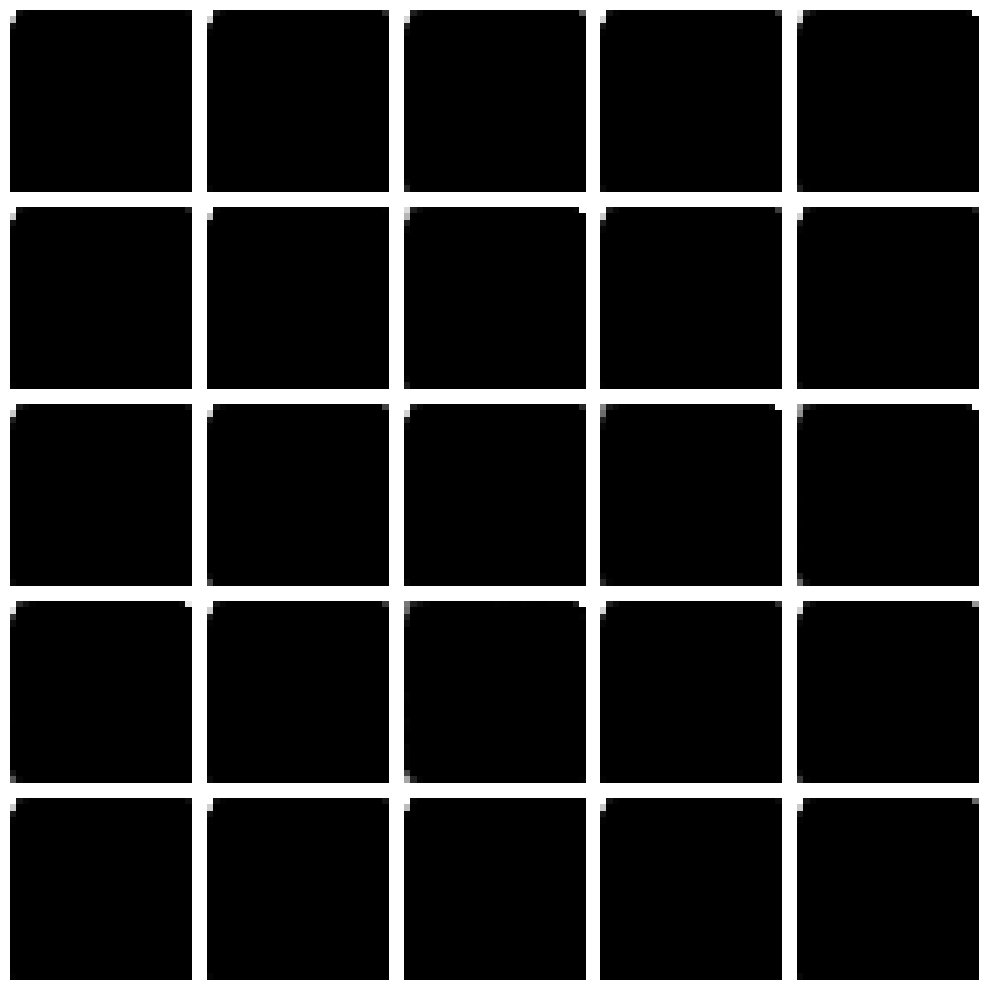


Original vs Reconstructed images:


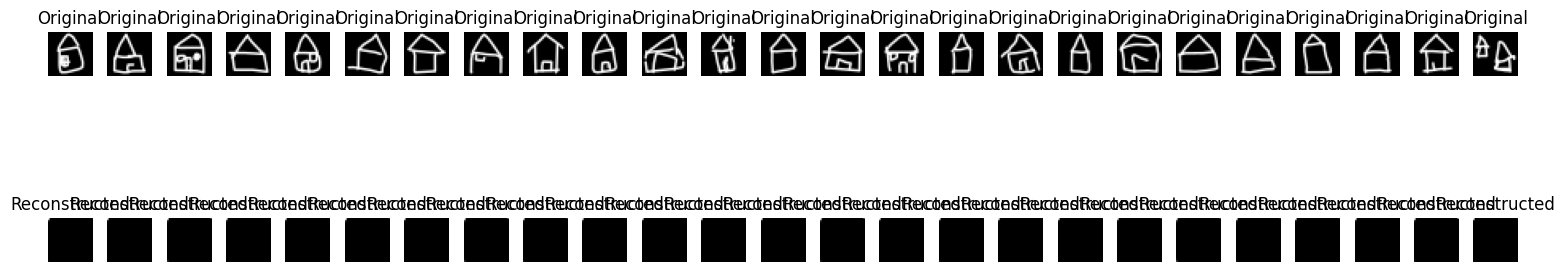


Pixel value ranges for generated images:
Min pixel value: 0.0
Max pixel value: 0.00019628011796157807
Mean pixel value: 1.592021163787649e-07


In [100]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Load the saved VAE model
new_vae = keras.models.load_model('trained_vae_model_5epoches.h5', 
                            custom_objects={'VAE': VAE})

def plot_generated_images(model, n=5):
    # Generate random latent vectors
    random_latent_points = tf.random.normal(shape=(n * n, LATENT_DIM))
    
    # Decode them to images
    generated_images = model.decoder(random_latent_points)
    
    # Rescale images 0 - 1
    generated_images = generated_images.numpy()
    
    # Plot images
    plt.figure(figsize=(10, 10))
    for i in range(n * n):
        plt.subplot(n, n, i + 1)
        plt.imshow(generated_images[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_reconstructed_images(model, x_test, n=5):
    # Select test images
    test_images = x_test[:n*n]
    
    # Encode and decode images
    encoded = model.encoder(test_images)
    z = model.sampling(encoded)
    reconstructed_images = model.decoder(z)
    
    # Plot original and reconstructed images
    plt.figure(figsize=(15, 5))
    
    # Plot original images
    for i in range(n * n):
        plt.subplot(2, n*n, i + 1)
        plt.imshow(test_images[i, :, :, 0], cmap='gray')
        plt.title('Original')
        plt.axis('off')
        
    # Plot reconstructed images  
    for i in range(n * n):
        plt.subplot(2, n*n, i + n*n + 1)
        plt.imshow(reconstructed_images[i, :, :, 0], cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Generate new images
print("Generated images:")
plot_generated_images(new_vae)

# Compare original vs reconstructed
print("\nOriginal vs Reconstructed images:")
plot_reconstructed_images(new_vae, x_test)

# Check pixel value ranges
def check_pixel_ranges(images):
    print(f"Min pixel value: {images.numpy().min()}")
    print(f"Max pixel value: {images.numpy().max()}")
    print(f"Mean pixel value: {images.numpy().mean()}")

# Generate some images and check their pixel ranges
random_latent_points = tf.random.normal(shape=(10, LATENT_DIM))
generated_images = new_vae.decoder(random_latent_points)
print("\nPixel value ranges for generated images:")
check_pixel_ranges(generated_images)
